# Pneumonia Detection

    Author Name:    Xiao Li

## Import Packages Etc

In [72]:
import keras
from keras import layers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, Input, GlobalMaxPooling2D
from keras.losses import categorical_crossentropy
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL

## Task 1: Load the data

In [2]:
# dataset name
dataset_name = 'chest_xray'

# assuming data is contained in a train, test and a validation set
train_data_dir = dataset_name + '/train/'
test_data_dir = dataset_name + '/test/'
val_data_dir = dataset_name + '/val/'

# Set up some parmaeters for data loading
sample_rate = 1.0

# desired dimensions of our images.
img_width, img_height = 162, 128

# different backends - Color input shape
if K.image_data_format() == 'channels_first':
    input_shape_rgb = (3, img_width, img_height)
else:
    input_shape_rgb = (img_width, img_height, 3)
    
# different backends - Grayscale input shape
if K.image_data_format() == 'channels_first':
    input_shape_gray = (1, img_width, img_height)
else:
    input_shape_gray = (img_width, img_height, 1)

### - The function of load image (RGB and Gray scale)

In [3]:
def load_image(directory):

    # Find the data through the directory path
    data_class_folders = [i for i in os.listdir(directory) if not (i.startswith('.') or i.startswith('Icon'))]
    num_classes = len(data_class_folders)
    
    # Initialise arrays for data storage
    X_data_rgb = np.ndarray((0, input_shape_rgb[0], input_shape_rgb[1], input_shape_rgb[2]), dtype=np.float)
    X_data_gray = np.ndarray((0, input_shape_gray[0], input_shape_gray[1]), dtype=np.float)
    y_data = np.ndarray(0, dtype=np.str)
    
    # Loop through the class folders
    for i, image_cls in enumerate(data_class_folders):
        
        print('\nProcessing class {}'.format(image_cls))
        image_class_folder = directory + image_cls + "/"
        
        # Generate filenames from the data folder and do sampling
        image_filenames = [image_class_folder + i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
        image_filenames = [i for i in image_filenames if (i.endswith(".jpg") or i.endswith(".png") or i.endswith(".jpeg"))]  # Only process image files
        image_filenames = random.sample(image_filenames, int(len(image_filenames) * sample_rate))
        
        # Create a data array for image data
        count = len(image_filenames)
        X_data_rgb_part = np.ndarray((count, input_shape_rgb[0], input_shape_rgb[1], input_shape_rgb[2]), dtype=np.float)
        X_data_gray_part = np.ndarray((count, input_shape_gray[0], input_shape_gray[1]), dtype=np.float)
        
        # Iterate throuigh the filenames and for each one load the image, resize and normalise
        for i, image_file in enumerate(image_filenames):
            
            # For read color file
            # Low the images and resize them
            image_rgb = cv2.imread(image_file, cv2.IMREAD_COLOR)
            image_rgb = cv2.resize(image_rgb, (img_height, img_width), interpolation = cv2.INTER_CUBIC)
            image_rgb = image_rgb[:,:,[2,1,0]] # OpenCV and matplotlib use differnet channel oerderings so fix this
        
            # If channel order of network does not match open cv format swap it
            if K.image_data_format() == 'channels_first':
                image_rgb = np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
        
            # Add image data to data array and normalise
            X_data_rgb_part[i] = image_rgb
            X_data_rgb_part[i] = X_data_rgb_part[i] / 255
            
            # For read gray scale file
            # Low the images and resize them - Gray scale
            image_gray = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            image_gray = cv2.resize(image_gray, (img_height, img_width), interpolation = cv2.INTER_CUBIC)
          
            # Add image data to data array and normalise
            X_data_gray_part[i] = image_gray
            X_data_gray_part[i] = X_data_gray_part[i] / 255
            
            # Add label to label array
            y_data = np.append(y_data, image_cls)
        
            if i % 100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))
                
        print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
        
        # Append the part to the overall data array
        X_data_rgb = np.append(X_data_rgb, X_data_rgb_part, axis = 0)
        X_data_gray = np.append(X_data_gray, X_data_gray_part, axis = 0)
        
    # Print the shape information
    print("\nDataShape:")
    print("- RGB: {}".format(X_data_rgb.shape))
    print("- Gray scale: {}".format(X_data_gray.shape))
    
    # Return the vetors
    return X_data_rgb, X_data_gray, y_data

### - Read the training set

In [4]:
X_train_rgb, X_train_gray, y_train = load_image(train_data_dir)


Processing class PNEUMONIA
Processed 0 of 3875 for class PNEUMONIA 
Processed 100 of 3875 for class PNEUMONIA 
Processed 200 of 3875 for class PNEUMONIA 
Processed 300 of 3875 for class PNEUMONIA 
Processed 400 of 3875 for class PNEUMONIA 
Processed 500 of 3875 for class PNEUMONIA 
Processed 600 of 3875 for class PNEUMONIA 
Processed 700 of 3875 for class PNEUMONIA 
Processed 800 of 3875 for class PNEUMONIA 
Processed 900 of 3875 for class PNEUMONIA 
Processed 1000 of 3875 for class PNEUMONIA 
Processed 1100 of 3875 for class PNEUMONIA 
Processed 1200 of 3875 for class PNEUMONIA 
Processed 1300 of 3875 for class PNEUMONIA 
Processed 1400 of 3875 for class PNEUMONIA 
Processed 1500 of 3875 for class PNEUMONIA 
Processed 1600 of 3875 for class PNEUMONIA 
Processed 1700 of 3875 for class PNEUMONIA 
Processed 1800 of 3875 for class PNEUMONIA 
Processed 1900 of 3875 for class PNEUMONIA 
Processed 2000 of 3875 for class PNEUMONIA 
Processed 2100 of 3875 for class PNEUMONIA 
Processed 2200 o

### - Read the testing set

In [5]:
X_test_rgb, X_test_gray, y_test = load_image(test_data_dir)


Processing class PNEUMONIA
Processed 0 of 390 for class PNEUMONIA 
Processed 100 of 390 for class PNEUMONIA 
Processed 200 of 390 for class PNEUMONIA 
Processed 300 of 390 for class PNEUMONIA 
Processed 390 of 390 for class PNEUMONIA 

Processing class NORMAL
Processed 0 of 234 for class NORMAL 
Processed 100 of 234 for class NORMAL 
Processed 200 of 234 for class NORMAL 
Processed 234 of 234 for class NORMAL 

DataShape:
- RGB: (624, 162, 128, 3)
- Gray scale: (624, 162, 128)


### - Read the validation set

In [6]:
X_val_rgb, X_val_gray, y_val = load_image(val_data_dir)


Processing class PNEUMONIA
Processed 0 of 8 for class PNEUMONIA 
Processed 8 of 8 for class PNEUMONIA 

Processing class NORMAL
Processed 0 of 8 for class NORMAL 
Processed 8 of 8 for class NORMAL 

DataShape:
- RGB: (16, 162, 128, 3)
- Gray scale: (16, 162, 128)


### - Print sample images

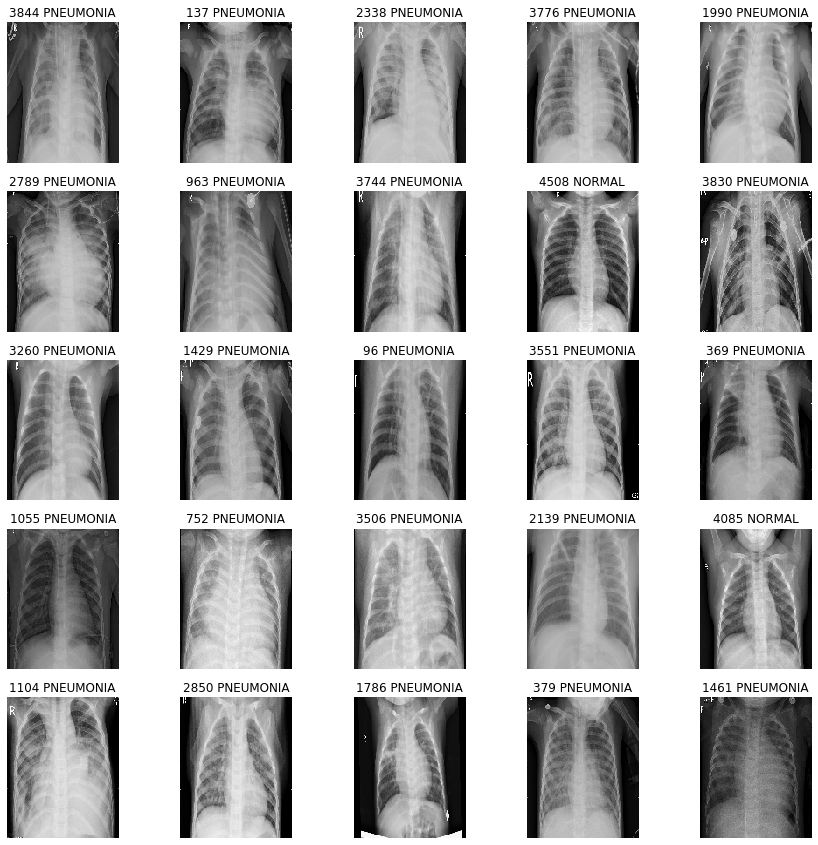

In [7]:
pltsize = 3
row_images = 5
col_images = 5
plt.figure(figsize=(col_images * pltsize, row_images * pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train_rgb.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(PIL.Image.fromarray(((X_train_rgb[i_rand]) * 255).astype(np.uint8)), cmap="gray")
    plt.title((str(i_rand) + " " + y_train[i_rand]))

## Task 2: Logistic regression

In [8]:
# Reshape the vertor to fit logistic regression
X_train_gray_lr = X_train_gray.reshape(X_train_gray.shape[0], X_train_gray.shape[1] * X_train_gray.shape[2])
X_val_gray_lr = X_val_gray.reshape(X_val_gray.shape[0], X_val_gray.shape[1] * X_val_gray.shape[2])
X_test_gray_lr = X_test_gray.reshape(X_test_gray.shape[0], X_test_gray.shape[1] * X_test_gray.shape[2])

In [11]:
# Generate the logistic regression
logreg = LogisticRegression()
logreg_model = logreg.fit(X_train_gray_lr, y_train)
y_pred = logreg_model.predict(X_train_gray_lr)
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00      1341
   PNEUMONIA       1.00      1.00      1.00      3875

    accuracy                           1.00      5216
   macro avg       1.00      1.00      1.00      5216
weighted avg       1.00      1.00      1.00      5216



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [12]:
# Testing the logistic regression
y_pred = logreg.predict(X_test_gray_lr)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.94      0.33      0.49       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.83      0.66      0.66       624
weighted avg       0.80      0.74      0.70       624



## Task 3: Convolution neural network (LeNet-5 model architecture)

In [13]:
# Reshape the vertor to fit logistic regression
X_train_gray_cnn = X_train_gray.reshape(X_train_gray.shape[0], X_train_gray.shape[1], X_train_gray.shape[2], 1)
X_val_gray_cnn = X_val_gray.reshape(X_val_gray.shape[0], X_val_gray.shape[1], X_val_gray.shape[2], 1)
X_test_gray_cnn = X_test_gray.reshape(X_test_gray.shape[0], X_test_gray.shape[1], X_test_gray.shape[2], 1)

### - Generate the LeNet-5 model

In [14]:
# Number of classes
num_classes = 2

# Use LabelEncoder to encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.fit_transform(y_val)
y_test_encoded = le.fit_transform(y_test)

# Covert class vectors to binary class matrics
y_train_cnn = to_categorical(y_train_encoded, num_classes)
y_val_cnn = to_categorical(y_val_encoded, num_classes)
y_test_cnn = to_categorical(y_test_encoded, num_classes)

In [15]:
# Genreate LeNet-5 model in 9 steps

# Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same', activation = 'relu', input_shape = (162, 128, 1)))

# S2 Pooling Layer
model.add(layers.MaxPool2D(strides = 2))

# C3 Convolutional Layer
model.add(layers.Conv2D(filters = 48, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))

# S4 Pooling Layer
model.add(layers.MaxPool2D(strides = 2))
 
# Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())
    
# C5 Fully Connected Convolutional Layer
model.add(layers.Dense(units = 256, activation = 'relu'))

# FC6 Fully Connected Layer
model.add(layers.Dense(units = 84, activation = 'relu'))

# Output Layer with softmax activation
model.add(layers.Dense(units = 2, activation = 'softmax'))

In [16]:
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 162, 128, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 81, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 60, 48)        38448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 30, 48)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 54720)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               14008576  
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

In [24]:
adam = Adam(lr = 5e-4)
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = adam)

In [28]:
# Set a learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [29]:
hist = model.fit(x = X_train_gray_cnn, 
                 y = y_train_cnn, 
                 epochs = 20, 
                 batch_size = 128, 
                 validation_data = (X_test_gray_cnn, y_test_cnn), 
                 verbose = 1,
                 callbacks = [reduce_lr])

Train on 5216 samples, validate on 624 samples
Epoch 1/20
5216/5216 [==============================] - 56s 11ms/step - loss: 0.4340 - accuracy: 0.8052 - val_loss: 0.7184 - val_accuracy: 0.6987
Epoch 2/20


/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


5216/5216 [==============================] - 60s 12ms/step - loss: 0.1176 - accuracy: 0.9557 - val_loss: 0.5940 - val_accuracy: 0.7933
Epoch 3/20
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0839 - accuracy: 0.9695 - val_loss: 1.3045 - val_accuracy: 0.7083
Epoch 4/20
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0710 - accuracy: 0.9745 - val_loss: 0.6651 - val_accuracy: 0.7997
Epoch 5/20
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0658 - accuracy: 0.9753 - val_loss: 0.9863 - val_accuracy: 0.7612
Epoch 6/20
5216/5216 [==============================] - 57s 11ms/step - loss: 0.0530 - accuracy: 0.9814 - val_loss: 0.8181 - val_accuracy: 0.7981
Epoch 7/20
5216/5216 [==============================] - 57s 11ms/step - loss: 0.0391 - accuracy: 0.9862 - val_loss: 1.0300 - val_accuracy: 0.7853
Epoch 8/20
5216/5216 [==============================] - 56s 11ms/step - loss: 0.0622 - accuracy: 0.9732 - val_loss: 1.2944 - val_accura

### - Evaluate the model

In [30]:
test_score = model.evaluate(X_test_gray_cnn, y_test_cnn, batch_size = 128)
print("Test loss: {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1]*100))

624/624 [==============================] - 1s 2ms/step
Test loss: 2.8140, accuracy 75.32%


### - Visualize the Training Process

Text(0, 0.5, 'acc')

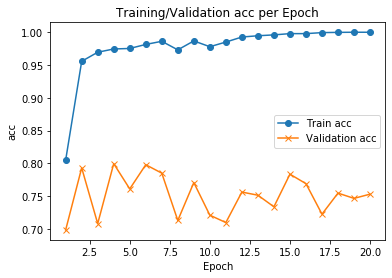

In [31]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['accuracy'], 'o-')
ax.plot([None] + hist.history['val_accuracy'], 'x-')
        
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

Text(0, 0.5, 'Loss')

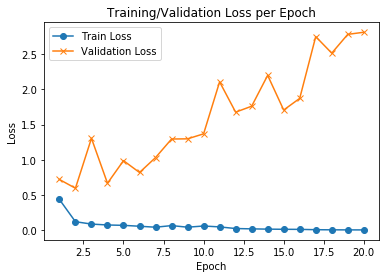

In [32]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'], 'o-')
ax.plot([None] + hist.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [33]:
# Testing the LeNet-5 model
y_pred_cnn = model.predict_classes(X_test_gray_cnn)
print(metrics.classification_report(y_test_encoded, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.98      0.35      0.52       234
           1       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.85      0.67      0.68       624
weighted avg       0.82      0.75      0.71       624



## Task 4: Data augmentation

In [34]:
# Create data generator (Random Brightness Augmentation)
datagen = ImageDataGenerator(rotation_range = 10, 
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.1)
# Compute quantities required for featurewise normalization
datagen.fit(X_train_gray_cnn)

In [35]:
hist = model.fit_generator(datagen.flow(X_train_gray_cnn, y_train_cnn, batch_size = 128), 
                           steps_per_epoch = len(X_train_gray_cnn) / 128, 
                           validation_data = (X_test_gray_cnn, y_test_cnn), 
                           verbose = 1,
                           epochs = 20, 
                           callbacks = [reduce_lr])

Epoch 1/20
41/40 [==============================] - 56s 1s/step - loss: 0.5710 - accuracy: 0.7684 - val_loss: 0.4077 - val_accuracy: 0.8237
Epoch 2/20


/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


41/40 [==============================] - 57s 1s/step - loss: 0.2920 - accuracy: 0.8773 - val_loss: 0.4669 - val_accuracy: 0.8045
Epoch 3/20
41/40 [==============================] - 55s 1s/step - loss: 0.2332 - accuracy: 0.9059 - val_loss: 0.5053 - val_accuracy: 0.8077
Epoch 4/20
41/40 [==============================] - 58s 1s/step - loss: 0.2092 - accuracy: 0.9105 - val_loss: 0.5224 - val_accuracy: 0.8093
Epoch 5/20
41/40 [==============================] - 55s 1s/step - loss: 0.1962 - accuracy: 0.9222 - val_loss: 0.3479 - val_accuracy: 0.8590
Epoch 6/20
41/40 [==============================] - 55s 1s/step - loss: 0.1854 - accuracy: 0.9237 - val_loss: 0.5881 - val_accuracy: 0.7885
Epoch 7/20
41/40 [==============================] - 55s 1s/step - loss: 0.1642 - accuracy: 0.9339 - val_loss: 0.6945 - val_accuracy: 0.7644
Epoch 8/20
41/40 [==============================] - 54s 1s/step - loss: 0.1619 - accuracy: 0.9348 - val_loss: 0.4706 - val_accuracy: 0.8253
Epoch 9/20
41/40 [=============

### - Evaluate the model

In [36]:
test_score = model.evaluate(X_test_gray_cnn, y_test_cnn)
print("Test loss: {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1]*100))

624/624 [==============================] - 2s 3ms/step
Test loss: 0.5775, accuracy 83.97%


### - Visualize the Training Process

Text(0, 0.5, 'acc')

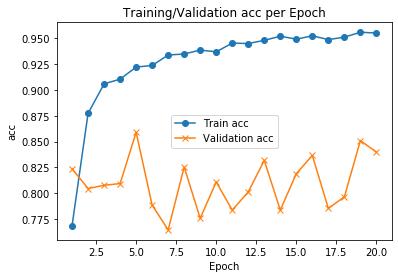

In [37]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['accuracy'], 'o-')
ax.plot([None] + hist.history['val_accuracy'], 'x-')
        
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

Text(0, 0.5, 'Loss')

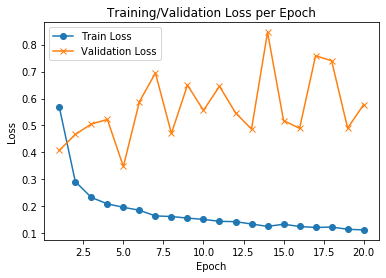

In [38]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'], 'o-')
ax.plot([None] + hist.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

## Task 5: Pre-trained model

In [76]:
# Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = X_train_rgb[0].shape)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0     

In [77]:
# Set the 5th block of the VGG16 model as the last output layer.
last_layer = model_vgg16_conv.get_layer('block5_pool')
last_output = last_layer.output

In [78]:
# Create a new output layer for 2 class classification.
new_last_layers = GlobalMaxPooling2D()(last_output)

# Add a fully connected layer with 512 hidden units and ReLU activation
new_last_layers = Dense(512, activation='relu')(new_last_layers)

# Add a dropout rate of 0.5
new_last_layers = Dropout(0.5)(new_last_layers)

# Add a final sigmoid layer for classification
new_last_layers = layers.Dense(2, activation='sigmoid')(new_last_layers)

In [80]:
# Combine the VGG 16 with the output layer.
model = Model(model_vgg16_conv.input, new_last_layers)

# Compile
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = adam)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0   

In [83]:
# Freeze the layers except the last 4 layers
for layer in model_vgg16_conv.layers[:-1]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in model_vgg16_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x1a9d11ae50> False
<keras.layers.convolutional.Conv2D object at 0x1a9d11abd0> False
<keras.layers.convolutional.Conv2D object at 0x1a9d11a650> False
<keras.layers.pooling.MaxPooling2D object at 0x1a9d11a050> False
<keras.layers.convolutional.Conv2D object at 0x1a940f2fd0> False
<keras.layers.convolutional.Conv2D object at 0x1aa0e8f850> False
<keras.layers.pooling.MaxPooling2D object at 0x1a94150e10> False
<keras.layers.convolutional.Conv2D object at 0x1a94146250> False
<keras.layers.convolutional.Conv2D object at 0x1a9411f750> False
<keras.layers.convolutional.Conv2D object at 0x1a94114090> False
<keras.layers.pooling.MaxPooling2D object at 0x1a94114bd0> False
<keras.layers.convolutional.Conv2D object at 0x1a940f8b10> False
<keras.layers.convolutional.Conv2D object at 0x1a94036dd0> False
<keras.layers.convolutional.Conv2D object at 0x1a9d118e10> False
<keras.layers.pooling.MaxPooling2D object at 0x1a9d13a150> False
<keras.layers.convoluti

In [85]:
hist = model.fit(x = X_train_rgb, 
                 y = y_train_cnn, 
                 epochs = 20, 
                 batch_size = 128, 
                 validation_data = (X_test_rgb, y_test_cnn), 
                 verbose = 1,
                 callbacks = [reduce_lr])

Train on 5216 samples, validate on 624 samples
Epoch 1/20
5216/5216 [==============================] - 176s 34ms/step - loss: 0.3547 - accuracy: 0.7552 - val_loss: 0.5162 - val_accuracy: 0.6346
Epoch 2/20


/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


5216/5216 [==============================] - 166s 32ms/step - loss: 0.2111 - accuracy: 0.8988 - val_loss: 0.4885 - val_accuracy: 0.8077
Epoch 3/20
5216/5216 [==============================] - 164s 31ms/step - loss: 0.1210 - accuracy: 0.9532 - val_loss: 0.4459 - val_accuracy: 0.8381
Epoch 4/20
5216/5216 [==============================] - 166s 32ms/step - loss: 0.1041 - accuracy: 0.9630 - val_loss: 0.5816 - val_accuracy: 0.8173
Epoch 5/20
5216/5216 [==============================] - 176s 34ms/step - loss: 0.1018 - accuracy: 0.9613 - val_loss: 0.8626 - val_accuracy: 0.7564
Epoch 6/20
5216/5216 [==============================] - 185s 35ms/step - loss: 0.0898 - accuracy: 0.9678 - val_loss: 0.5864 - val_accuracy: 0.8173
Epoch 7/20
5216/5216 [==============================] - 188s 36ms/step - loss: 0.0851 - accuracy: 0.9697 - val_loss: 0.5816 - val_accuracy: 0.8205
Epoch 8/20
5216/5216 [==============================] - 191s 37ms/step - loss: 0.0909 - accuracy: 0.9688 - val_loss: 0.8535 - val

### - Evaluate the model

In [86]:
test_score = model.evaluate(X_test_rgb, y_test_cnn, batch_size = 128)
print("Test loss: {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1]*100))

624/624 [==============================] - 16s 25ms/step
Test loss: 0.9160, accuracy 78.04%


### - Visualize the Training Process

Text(0, 0.5, 'acc')

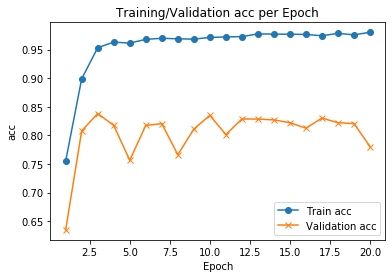

In [87]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['accuracy'], 'o-')
ax.plot([None] + hist.history['val_accuracy'], 'x-')
        
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

Text(0, 0.5, 'Loss')

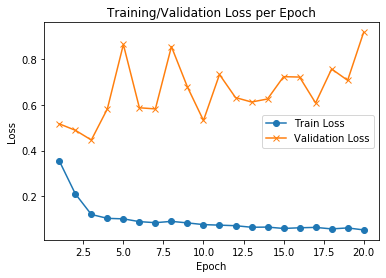

In [88]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'], 'o-')
ax.plot([None] + hist.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

## Task 6: Reflection

    Accurary Result from previous sections:

        Logistic Regression: 0.74
        LeNet-5 Model: 0.75
        LeNet-5 with Data Augmentation: 0.84
        VGG-16 Model: 0.78
 